<a href="https://colab.research.google.com/github/shardul28/political-stance-detection/blob/Mscproject/16-4-22SUUUUiiiiiiiiiiiiiiiiiiiiii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [243]:
!pip install mit-news-classify


In [244]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [245]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
import pickle
from mitnewsclassify import tfidf as mitx
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict,Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [246]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [247]:
cd /content/drive/MyDrive/project_data

/content/drive/MyDrive/project_data


# Fetching Data from Drive

In [248]:
infile = open('ndtv_data.pkl','rb')
ndtv_df = pickle.load(infile)

In [249]:
ndtv_df.head()

,text,url,title,content,left 0 right 1,retweet_count,favorite_count,source_name,source
0,"Army Officer, 4 Others Killed In Encounter In ...",https://www.ndtv.com/india-news/army-officer-4...,"Army Officer, 4 Personnel Killed In Encounter ...",an army officer and four other personnel were ...,NaN,9,63,ndtv,0
1,"#AryanKhan Case: No Bail For Him Today, Next H...",https://ndtv.com/india-news/mumbai-drug-bust-c...,"Aryan Khan Case: No Bail For Him Today, Next H...",aryan khan did not get bail today for the thir...,NaN,5,44,ndtv,0
2,RT @ndtvfeed: Ex-National Conference Leaders D...,https://www.ndtv.com/india-news/after-resignin...,"Ex-National Conference Leaders Devender Rana, ...",a day after resigning from the national confer...,1.0,2,0,ndtv,0
3,"RT @ndtvfeed: US Has Lost AI Battle To China, ...",https://www.ndtv.com/world-news/us-has-lost-ar...,"US Has Lost AI Battle To China, Pentagon's Ex-...",china has won the artificial intelligence batt...,0.0,5,0,ndtv,0
4,RT @ndtvfeed: A Look At Inspiring Messages On ...,https://www.ndtv.com/india-news/on-internation...,International Day Of The Girl Child 2021: Lead...,various world leaders and un agencies posted w...,NaN,3,0,ndtv,0


In [250]:
infile2 = open('republic_data.pkl','rb')
republic_df = pickle.load(infile2)

In [251]:
republic_df.count()


text              2196
url               2196
title             2196
content           2196
left 0 right 1    1297
retweet_count     2196
favorite_count    2196
source_name       2636
source            2636
dtype: int64

In [252]:
ndtv_df.count()


text              1371
url               1371
title             1371
content           1371
left 0 right 1     329
retweet_count     1371
favorite_count    1371
source_name       1371
source            1371
dtype: int64

In [253]:
republic_df=republic_df.head(1075)
ndtv_df=ndtv_df.head(1075)



In [254]:
republic_df.count()


text              1075
url               1075
title             1075
content           1075
left 0 right 1     176
retweet_count     1075
favorite_count    1075
source_name       1075
source            1075
dtype: int64

In [255]:
republic_df.tail()

,text,url,title,content,left 0 right 1,retweet_count,favorite_count,source_name,source
1070,Kerala HC quashes state govt order of reducing...,https://www.republicworld.com/india-news/law-a...,Kerala HC Quashes State Govt Order Of Reducing...,the kerala high court quashed the state govern...,NaN,4.0,21.0,republictv,1
1071,Lakhimpur Kheri violence: Yogi Adityanath hold...,https://www.republicworld.com/india-news/gener...,Lakhimpur Kheri Violence: Yogi Adityanath Hold...,chief minister yogi adityanath on monday held ...,1.0,7.0,72.0,republictv,1
1072,"IPL 2021: Know how KKR, PBKS, RR, &amp; MI can...",https://www.republicworld.com/sports-news/cric...,"IPL 2021: Know How KKR, PBKS, RR, & MI Can Qua...",the ongoing edition of the indian premier leag...,NaN,4.0,20.0,republictv,1
1073,Lakhimpur clash: Priyanka Gandhi protests deta...,https://www.republicworld.com/india-news/polit...,Lakhimpur Clash: Priyanka Gandhi Protests Deta...,"in a mark of silent protest, congress general ...",0.0,4.0,24.0,republictv,1
1074,Lakhimpur Kheri violence | UP Govt denies perm...,https://www.republicworld.com/india-news/gener...,Lakhimpur Kheri Violence | UP Govt Denies Perm...,punjab chief minister charanjit singh channi o...,NaN,7.0,47.0,republictv,1


In [256]:
##CHECKING NULL VALUES
print(republic_df.isna().sum())


text                0
url                 0
title               0
content             0
left 0 right 1    899
retweet_count       0
favorite_count      0
source_name         0
source              0
dtype: int64


In [257]:
print(ndtv_df.isna().sum())


text                0
url                 0
title               0
content             0
left 0 right 1    804
retweet_count       0
favorite_count      0
source_name         0
source              0
dtype: int64


In [258]:
republic_df=republic_df.dropna(subset=['content'])
ndtv_df=ndtv_df.dropna(subset=['content'])


In [259]:
##bias=left 0 right 1 unbiased 3

In [260]:
ndtv_df.rename(columns = {'left 0 right 1':'bias'}, inplace = True)
ndtv_df=ndtv_df.fillna({'bias':3})
ndtv_df['bias']=ndtv_df['bias'].astype(int)

In [261]:
republic_df.columns

Index(['text', 'url', 'title', 'content', 'left 0 right 1', 'retweet_count',
       'favorite_count', 'source_name', 'source'],
      dtype='object')

In [262]:
republic_df.rename(columns = {'left 0 right 1':'bias'}, inplace = True)
republic_df=republic_df.fillna({'bias':3})
republic_df['bias']=republic_df['bias'].astype(int)

In [263]:
print(republic_df.isna().sum())


text              0
url               0
title             0
content           0
bias              0
retweet_count     0
favorite_count    0
source_name       0
source            0
dtype: int64


In [264]:
print(ndtv_df.isna().sum())


text              0
url               0
title             0
content           0
bias              0
retweet_count     0
favorite_count    0
source_name       0
source            0
dtype: int64


In [265]:
republic_df.bias.value_counts()

3    899
0     93
1     83
Name: bias, dtype: int64

In [266]:
ndtv_df.bias

0       3
1       3
2       1
3       0
4       3
       ..
1070    3
1071    3
1072    3
1073    3
1074    3
Name: bias, Length: 1075, dtype: int64

# DATA CLEANING

In [267]:
# ps.stem("army")

In [268]:
# ps.stem("united states")


# STOPWORDS

In [269]:
# A list of common english words which should not affect predictions
stopwordslist = ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone',
             'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount',
             'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around',
             'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before',
             'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both',
             'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'cry', 'de',
             'describe', 'detail', 'did', 'do', 'does', 'doing', 'don', 'done', 'down', 'due', 'during', 'each', 'eg',
             'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone',
             'everything', 'everywhere', 'except', 'few', 'fifteen', 'fify', 'fill', 'find', 'fire', 'first', 'five', 'for',
             'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had',
             'has', 'hasnt', 'have', 'having', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed',
             'interest', 'into', 'is', 'it', 'its', 'itself', 'just', 'keep', 'last', 'latter', 'latterly', 'least', 'less',
             'ltd', 'made', 'many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine', 'more', 'moreover', 'most', 'mostly',
             'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'never', 'nevertheless', 'next', 'nine',
             'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once',
             'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own',
             'part', 'per', 'perhaps', 'please', 'put', 'rather', 're', 's', 'same', 'see', 'seem', 'seemed', 'seeming',
             'seems', 'serious', 'several', 'she', 'should', 'show', 'side', 'since', 'sincere', 'six', 'sixty', 'so', 
             'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'system',
             't', 'take', 'ten', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there',
             'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'thickv', 'thin', 'third', 'this',
             'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'top', 'toward',
             'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'until', 'up', 'upon', 'us', 'very', 'via', 'was', 'we',
             'well', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby',
             'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom',
             'whose', 'why', 'will', 'with', 'within', 'without', 'would', 'yet', 'you', 'your', 'yours', 'yourself',
             'yourselves']

In [270]:
final_stop_words = stopwords.words('english')+stopwordslist+['an','today','ndtv', 'ndtvfeed','story','edited','staff','syndicated','published','headline','feed']#['shiv sena','shivsena','aap','bjp','congress','said','also','minister']

In [228]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
stop_words=final_stop_words
for i in range(0, len(ndtv_df)):
    #print(i)
    review = re.sub('[^a-zA-Z]', ' ', ndtv_df['content'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
ndtv_df['clean_content']=corpus

In [229]:
corpus = []
for i in range(0, len(republic_df)):
    #print(i)
    review = re.sub('[^a-zA-Z]', ' ', republic_df['content'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
republic_df['clean_content']=corpus

In [230]:
from string import punctuation
punc=list(punctuation)
punc

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [231]:
import string
re.sub('[^a-zA-Z'+string.punctuation+']', ' ','abcm,.jasjsa')
re.sub(r'[^a-zA-Z,.!(){}]', ' ','#$%&@~ !! AA @@abcm,.jasjsa')


'       !! AA   abcm,.jasjsa'

In [232]:
### Dataset Preprocessing ###
###'clean_content_with_Stopwords' we are creating this because the scraped data had special characters like 'š','â' , we need this data for sentiment analysis
stop_words = stopwords.words('english')+['an','today','ndtv', 'ndtvfeed']#['shiv sena','shivsena','aap','bjp','congress','said','also','minister']
from nltk.stem.porter import PorterStemmer
import string
ps = PorterStemmer()
corpus = []
for i in range(0, len(ndtv_df)):
    #print(i)
    review = re.sub(r'[^a-zA-Z,.!(){}]'+']', ' ', ndtv_df['content'][i])
    #review = re.sub('[#$%&@~!_]', ' ',  ndtv_df['content'][i])
    review = review.lower()
    review = review.split()
    review = ' '.join(review)
    corpus.append(review)
ndtv_df['clean_content_with_Stopwords']=corpus
corpus = []
for i in range(0, len(republic_df)):
    #print(i)
    review = re.sub(r'[^a-zA-Z,.!(){}]', ' ', republic_df['content'][i])
    #review = re.sub('[#$%&@~!_]', ' ', republic_df['content'][i])
    review = review.lower()
    review = review.split()
    review = ' '.join(review)
    corpus.append(review)
republic_df['clean_content_with_Stopwords']=corpus

In [233]:
ndtv_df['clean_content_with_Stopwords'][0]


"an army officer and four other personnel were killed in action during an encounter between security forces and terrorists in jammu and kashmir's poonch district on monday, officials said. an anti-insurgency operation was launched in a village close to dera ki gali in surankote in the early hours following intelligence inputs about the presence of heavily-armed terrorists there, they said. the hiding terrorists fired on the search parties resulting in fierce gunfight and critical injuries to a junior commissioned officer or jco and four other soldiers. they died from their injuries. the encounter with the terrorists was going on and further details are awaited, a defence spokesperson said. officials said there were reports about the presence of a group of heavily-armed terrorists in the chamrer forest, after they managed to sneak from across the line of control (loc). reinforcements have been rushed to the area to plug all escape routes of the terrorists, they said. (with inputs from p

#MIT News Classify

In [234]:
# MIT News Classify is a package containing several natural language processing (NLP) and ML-based models that have been finetuned on an Annotated Corpus and its predefined news tags.

In [235]:
ndtv_df['content'][0]

"an army officer and four other personnel were killed in action during an encounter between security forces and terrorists in jammu and kashmir's poonch district on monday, officials said. an anti-insurgency operation was launched in a village close to dera ki gali in surankote in the early hours following intelligence inputs about the presence of heavily-armed terrorists there, they said. the hiding terrorists fired on the search parties resulting in fierce gunfight and critical injuries to a junior commissioned officer or jco and four other soldiers. they died from their injuries. the encounter with the terrorists was going on and further details are awaited, a defence spokesperson said. officials said there were reports about the presence of a group of heavily-armed terrorists in the chamrer forest, after they managed to sneak from across the line of control (loc). reinforcements have been rushed to the area to plug all escape routes of the terrorists, they said. (with inputs from p

In [236]:
mitx.gettags(ndtv_df['content'][0])

['terrorism', 'armament, defense and military forces']

In [271]:
ndtv_df['content'][1]

'aryan khan did not get bail today for the third time since his arrest a week ago in the drugs-on-cruise case. his bail request will be heard on wednesday after the narcotics control bureau (ncb) gives its statement to the court. aryan khan, the 23-year-old son of actor shah rukh khan, has been in a mumbai jail since friday. he and his friend arbazz merchant were was among nine arrested after anti-drugs officials raided a cruise rave party in disguise. the anti-drugs agency had asked the court to extend his custody till friday for more time to file its reply. the court ordered the ncb to do so by wednesday morning instead, posting aryan khan\'s bail plea hearing to wednesday instead. arguing aryan khan\'s case, lawyer amit desai had requested that his request for bail be heard today. no drugs were found on him, the lawyer said. "the offence involves only a one-year sentence. for this child, seven days is not suitable," mr desai had said. but the ncb insisted it was not ready with its s

In [272]:
mitx.gettags(ndtv_df['content'][1])


['drug abuse and traffic']

In [273]:
republic_df['content'][0]


'in a recent update to the covid situation in kerala, the cpm-led kerala government on saturday, october 9, admitted on the floor of the state assembly of underreporting over 7,000 virus-related deaths in the total tally. the chairperson of the national immunisation technical advisory group (ntagi), dr nk arora, highlighting the reason for \'under-reporting\' of covid deaths, explains the process of uploading the data to the national portal. he said that kerala is not the only state where the backlog of deaths was reported but there are many states that have been late in updating the information. according to national centre for disease control (ncdc), there is great difficulty in getting accurate information on hospitalisation which is very important as it helps to understand the health system leads. however, most of the states have incomplete data concerned with hospitalisation. he further urged ncdc to work with the state to resolve the issue. further applauding the kerala governmen

In [274]:
mitx.gettags(republic_df['content'][0])

['medicine and health',
 'diseases and conditions',
 'vaccination and immunization']

In [275]:
republic_df['content'][1]

'a kerala-based artist created an installation using biscuits and other bakery products to reflect kerala\'s ceremonial art genre theyyam. suresh, also known as \'davinci,\' spent nearly 15 hours creating the massive 24-foot long art installation. the art installation was created in the hall of a kannur bakery using numerous tables arranged in the centre of the room. the face of theyyam was created using up to 25,000 biscuits of various colours and sizes, as well as other bakery products. suresh was invited to make the art piece in chef muhammad rashid\'s bakery, \'bake story.\' "we have invited davinci suresh, who made the artwork of north malabar\'s traditional art form theyyam using bakery items. bake story bakery from kannur also became part of davinci suresh\'s 100 medium plan," remarked the chef. after that, all of the bakery products were given to a veterinary farm to biodegrade. similarly, on thursday, october 7, the odisha lalit kala akademi, in collaboration with the koraput 

In [276]:
mitx.gettags(republic_df['content'][1])

['art', 'food', 'bakeries and baked products']

In [277]:
len(republic_df)

1075

In [278]:
mitx.gettags(republic_df['content'][0])


['medicine and health',
 'diseases and conditions',
 'vaccination and immunization']

In [279]:
# ##the MIT PACKAGE IDENTIFIES TAGS AS BOTH THE ORIGINAL TAG AND WITH UNITED TAGS
# for ex.
# ['united states politics and government',
#  'politics and government',
#  'united states international relations',
#  'international relations']


#  this can be just 
#  ['politics and government',
#  'international relations']

In [237]:
listx=[]
for x1 in range(len(republic_df)):
  templist=[]
  test=mitx.gettags(republic_df['content'][x1])
  for temp in test:
    if temp.find("united states") != -1:
      continue
    else:
      templist.append(temp)
  listx.append(templist)

In [238]:
republic_df['tags']=listx

In [239]:
listx=[]
for x1 in range(len(ndtv_df)):
  templist=[]
  test=mitx.gettags(ndtv_df['content'][x1])
  for temp in test:
    if temp.find("united states") != -1:
      continue
    else:
      templist.append(temp)
  listx.append(templist)

In [240]:
ndtv_df['tags']=listx


In [241]:
ndf=ndtv_df
rdf=republic_df

In [242]:
ndf.head()

,text,url,title,content,bias,retweet_count,favorite_count,source_name,source,clean_content,clean_content_with_Stopwords,tags
0,"Army Officer, 4 Others Killed In Encounter In ...",https://www.ndtv.com/india-news/army-officer-4...,"Army Officer, 4 Personnel Killed In Encounter ...",an army officer and four other personnel were ...,3,9,63,ndtv,0,armi offic four personnel kill action encount ...,an army officer and four other personnel were ...,"[terrorism, armament, defense and military for..."
1,"#AryanKhan Case: No Bail For Him Today, Next H...",https://ndtv.com/india-news/mumbai-drug-bust-c...,"Aryan Khan Case: No Bail For Him Today, Next H...",aryan khan did not get bail today for the thir...,3,5,44,ndtv,0,aryan khan get bail today third time sinc arre...,aryan khan did not get bail today for the thir...,[drug abuse and traffic]
2,RT @ndtvfeed: Ex-National Conference Leaders D...,https://www.ndtv.com/india-news/after-resignin...,"Ex-National Conference Leaders Devender Rana, ...",a day after resigning from the national confer...,1,2,0,ndtv,0,day resign nation confer devend rana former he...,a day after resigning from the national confer...,[appointments and executive changes]
3,"RT @ndtvfeed: US Has Lost AI Battle To China, ...",https://www.ndtv.com/world-news/us-has-lost-ar...,"US Has Lost AI Battle To China, Pentagon's Ex-...",china has won the artificial intelligence batt...,0,5,0,ndtv,0,china artifici intellig battl unit state head ...,china has won the artificial intelligence batt...,"[suspensions, dismissals and resignations, arm..."
4,RT @ndtvfeed: A Look At Inspiring Messages On ...,https://www.ndtv.com/india-news/on-internation...,International Day Of The Girl Child 2021: Lead...,various world leaders and un agencies posted w...,3,3,0,ndtv,0,variou world leader un agenc post wish messag ...,various world leaders and un agencies posted w...,"[women, children and youth]"


# Sentiment Analysis

In [280]:
# VADER works better with things like slang, emojis, etc — whereas TextBlob performs strongly with more formal language usage.Therefore we will use TextBlob.
from textblob import TextBlob


In [281]:
(ndf['clean_content_with_Stopwords'][0])

"an army officer and four other personnel were killed in action during an encounter between security forces and terrorists in jammu and kashmir's poonch district on monday, officials said. an anti-insurgency operation was launched in a village close to dera ki gali in surankote in the early hours following intelligence inputs about the presence of heavily-armed terrorists there, they said. the hiding terrorists fired on the search parties resulting in fierce gunfight and critical injuries to a junior commissioned officer or jco and four other soldiers. they died from their injuries. the encounter with the terrorists was going on and further details are awaited, a defence spokesperson said. officials said there were reports about the presence of a group of heavily-armed terrorists in the chamrer forest, after they managed to sneak from across the line of control (loc). reinforcements have been rushed to the area to plug all escape routes of the terrorists, they said. (with inputs from p

In [282]:
TextBlob(ndf['clean_content_with_Stopwords'][0]).sentiment.subjectivity
#TextBlob(ndf['content'][0]).sentiment.subjectivity


0.31875

In [283]:
TextBlob(ndf['clean_content_with_Stopwords'][0]).sentiment.polarity

-0.03125

Polarity

In [284]:
listx=[]
for x1 in range(len(ndf)):
  listx.append(TextBlob(ndf['clean_content_with_Stopwords'][x1]).sentiment.polarity)
ndf['polarity']=listx


In [285]:
listx=[]
for x1 in range(len(rdf)):
  listx.append(TextBlob(rdf['clean_content_with_Stopwords'][x1]).sentiment.polarity)
rdf['polarity']=listx


In [286]:
def getAnalysis(score):
  if score < 0:
    return "Negative"
  elif score == 0:
    return "Neutral"
  else:
    return "Positive"

In [287]:
rdf["polarity_score"] = rdf["polarity"].apply(getAnalysis)
ndf["polarity_score"] = ndf["polarity"].apply(getAnalysis)


In [288]:
rdf.head(5)

,text,url,title,content,bias,retweet_count,favorite_count,source_name,source,clean_content,clean_content_with_Stopwords,tags,polarity,polarity_score
0,"Why did Kerala have a backlog of 7,000 COVID-1...",https://www.republicworld.com/india-news/gener...,"Why Did Kerala Have A Backlog Of 7,000 COVID-1...",in a recent update to the covid situation in k...,3,3.0,6.0,republictv,1,recent updat covid situat kerala cpm led keral...,in a recent update to the covid situation in k...,"[medicine and health, diseases and conditions,...",0.096953,Positive
1,Kerala artist creates 24-foot-long Theyyam's f...,https://www.republicworld.com/india-news/city-...,Kerala Artist Creates 24-foot-long Theyyam's F...,a kerala-based artist created an installation ...,3,2.0,14.0,republictv,1,kerala base artist creat instal use biscuit ba...,a kerala based artist created an installation ...,"[art, food, bakeries and baked products]",-0.018981,Negative
2,"PM Modi launches Indian Space Association, hig...",https://www.republicworld.com/india-news/gener...,Govt as an enabler..': PM Modi Launches Indian...,modi modi on monday launched indian space sect...,1,4.0,27.0,republictv,1,modi modi monday launch indian space sector in...,modi modi on monday launched indian space sect...,[space],0.137161,Positive
3,"NEET Phase 2 registration 2021 to end today, h...",https://www.republicworld.com/india-news/educa...,"NEET Phase 2 Registration 2021 To End Today, H...",neet phase 2 registration: national testing ag...,3,1.0,5.0,republictv,1,neet phase registr nation test agenc end ongo ...,neet phase registration national testing agenc...,"[politics and government, elections, tests and...",0.111111,Positive
4,"US, UK issue advisory; warn citizens to avoid ...",https://www.republicworld.com/world-news/rest-...,"Leave immediately' | US, UK Issue Advisory; Wa...","the united states and britain on monday, 11 oc...",3,2.0,11.0,republictv,1,unit state britain monday octob ask citizen av...,"the united states and britain on monday, octob...","[terrorism, religion and churches, bombs and e...",-0.009491,Negative


In [289]:
ndf.head(5)


,text,url,title,content,bias,retweet_count,favorite_count,source_name,source,clean_content,clean_content_with_Stopwords,tags,polarity,polarity_score
0,"Army Officer, 4 Others Killed In Encounter In ...",https://www.ndtv.com/india-news/army-officer-4...,"Army Officer, 4 Personnel Killed In Encounter ...",an army officer and four other personnel were ...,3,9,63,ndtv,0,armi offic four personnel kill action encount ...,an army officer and four other personnel were ...,"[terrorism, armament, defense and military for...",-0.031250,Negative
1,"#AryanKhan Case: No Bail For Him Today, Next H...",https://ndtv.com/india-news/mumbai-drug-bust-c...,"Aryan Khan Case: No Bail For Him Today, Next H...",aryan khan did not get bail today for the thir...,3,5,44,ndtv,0,aryan khan get bail today third time sinc arre...,aryan khan did not get bail today for the thir...,[drug abuse and traffic],-0.018687,Negative
2,RT @ndtvfeed: Ex-National Conference Leaders D...,https://www.ndtv.com/india-news/after-resignin...,"Ex-National Conference Leaders Devender Rana, ...",a day after resigning from the national confer...,1,2,0,ndtv,0,day resign nation confer devend rana former he...,a day after resigning from the national confer...,[appointments and executive changes],0.084060,Positive
3,"RT @ndtvfeed: US Has Lost AI Battle To China, ...",https://www.ndtv.com/world-news/us-has-lost-ar...,"US Has Lost AI Battle To China, Pentagon's Ex-...",china has won the artificial intelligence batt...,0,5,0,ndtv,0,china artifici intellig battl unit state head ...,china has won the artificial intelligence batt...,"[suspensions, dismissals and resignations, arm...",0.008113,Positive
4,RT @ndtvfeed: A Look At Inspiring Messages On ...,https://www.ndtv.com/india-news/on-internation...,International Day Of The Girl Child 2021: Lead...,various world leaders and un agencies posted w...,3,3,0,ndtv,0,variou world leader un agenc post wish messag ...,various world leaders and un agencies posted w...,"[women, children and youth]",0.102905,Positive


Subjectivity

In [290]:
listx=[]
for x1 in range(len(ndf)):
  listx.append(TextBlob(ndf['clean_content_with_Stopwords'][x1]).sentiment.subjectivity)
ndf['subjectivity']=listx


In [291]:
listx=[]
for x1 in range(len(rdf)):
  listx.append(TextBlob(rdf['clean_content_with_Stopwords'][x1]).sentiment.subjectivity)
rdf['subjectivity']=listx


In [ ]:
ndf.head()

In [ ]:
rdf.head()

In [294]:
def getsubAnalysis(score):
  if score > 0.5:
    return "High subjectivity"
  else:
    return "Low subjectivity"

In [295]:
rdf["subjectivity_score"] = rdf["subjectivity"].apply(getsubAnalysis)
ndf["subjectivity_score"] = ndf["subjectivity"].apply(getsubAnalysis)


In [296]:
rdf.head()

,text,url,title,content,bias,retweet_count,favorite_count,source_name,source,clean_content,clean_content_with_Stopwords,tags,polarity,polarity_score,subjectivity,subjectivity_score
0,"Why did Kerala have a backlog of 7,000 COVID-1...",https://www.republicworld.com/india-news/gener...,"Why Did Kerala Have A Backlog Of 7,000 COVID-1...",in a recent update to the covid situation in k...,3,3.0,6.0,republictv,1,recent updat covid situat kerala cpm led keral...,in a recent update to the covid situation in k...,"[medicine and health, diseases and conditions,...",0.096953,Positive,0.471889,Low subjectivity
1,Kerala artist creates 24-foot-long Theyyam's f...,https://www.republicworld.com/india-news/city-...,Kerala Artist Creates 24-foot-long Theyyam's F...,a kerala-based artist created an installation ...,3,2.0,14.0,republictv,1,kerala base artist creat instal use biscuit ba...,a kerala based artist created an installation ...,"[art, food, bakeries and baked products]",-0.018981,Negative,0.414815,Low subjectivity
2,"PM Modi launches Indian Space Association, hig...",https://www.republicworld.com/india-news/gener...,Govt as an enabler..': PM Modi Launches Indian...,modi modi on monday launched indian space sect...,1,4.0,27.0,republictv,1,modi modi monday launch indian space sector in...,modi modi on monday launched indian space sect...,[space],0.137161,Positive,0.557935,High subjectivity
3,"NEET Phase 2 registration 2021 to end today, h...",https://www.republicworld.com/india-news/educa...,"NEET Phase 2 Registration 2021 To End Today, H...",neet phase 2 registration: national testing ag...,3,1.0,5.0,republictv,1,neet phase registr nation test agenc end ongo ...,neet phase registration national testing agenc...,"[politics and government, elections, tests and...",0.111111,Positive,0.728858,High subjectivity
4,"US, UK issue advisory; warn citizens to avoid ...",https://www.republicworld.com/world-news/rest-...,"Leave immediately' | US, UK Issue Advisory; Wa...","the united states and britain on monday, 11 oc...",3,2.0,11.0,republictv,1,unit state britain monday octob ask citizen av...,"the united states and britain on monday, octob...","[terrorism, religion and churches, bombs and e...",-0.009491,Negative,0.392130,Low subjectivity


In [297]:
ndf.head()

,text,url,title,content,bias,retweet_count,favorite_count,source_name,source,clean_content,clean_content_with_Stopwords,tags,polarity,polarity_score,subjectivity,subjectivity_score
0,"Army Officer, 4 Others Killed In Encounter In ...",https://www.ndtv.com/india-news/army-officer-4...,"Army Officer, 4 Personnel Killed In Encounter ...",an army officer and four other personnel were ...,3,9,63,ndtv,0,armi offic four personnel kill action encount ...,an army officer and four other personnel were ...,"[terrorism, armament, defense and military for...",-0.031250,Negative,0.318750,Low subjectivity
1,"#AryanKhan Case: No Bail For Him Today, Next H...",https://ndtv.com/india-news/mumbai-drug-bust-c...,"Aryan Khan Case: No Bail For Him Today, Next H...",aryan khan did not get bail today for the thir...,3,5,44,ndtv,0,aryan khan get bail today third time sinc arre...,aryan khan did not get bail today for the thir...,[drug abuse and traffic],-0.018687,Negative,0.407323,Low subjectivity
2,RT @ndtvfeed: Ex-National Conference Leaders D...,https://www.ndtv.com/india-news/after-resignin...,"Ex-National Conference Leaders Devender Rana, ...",a day after resigning from the national confer...,1,2,0,ndtv,0,day resign nation confer devend rana former he...,a day after resigning from the national confer...,[appointments and executive changes],0.084060,Positive,0.199474,Low subjectivity
3,"RT @ndtvfeed: US Has Lost AI Battle To China, ...",https://www.ndtv.com/world-news/us-has-lost-ar...,"US Has Lost AI Battle To China, Pentagon's Ex-...",china has won the artificial intelligence batt...,0,5,0,ndtv,0,china artifici intellig battl unit state head ...,china has won the artificial intelligence batt...,"[suspensions, dismissals and resignations, arm...",0.008113,Positive,0.385273,Low subjectivity
4,RT @ndtvfeed: A Look At Inspiring Messages On ...,https://www.ndtv.com/india-news/on-internation...,International Day Of The Girl Child 2021: Lead...,various world leaders and un agencies posted w...,3,3,0,ndtv,0,variou world leader un agenc post wish messag ...,various world leaders and un agencies posted w...,"[women, children and youth]",0.102905,Positive,0.209667,Low subjectivity


In [298]:
with open('/content/drive/MyDrive/project_data/ndtv_data_with_classification_and_sentiment.pkl', 'wb') as fid:
     pickle.dump(ndf, fid)
with open('/content/drive/MyDrive/project_data/republic_data_with_classification_and_sentiment.pkl', 'wb') as fid:
     pickle.dump(rdf, fid)

# Exploratory data analysis
#(EDA)

In [299]:
infile = open('ndtv_data_with_classification_and_sentiment.pkl','rb')
ndf = pickle.load(infile)

In [300]:
infile = open('republic_data_with_classification_and_sentiment.pkl','rb')
rdf = pickle.load(infile)

In [73]:
ndf.head(3)

,text,url,title,content,bias,retweet_count,favorite_count,source_name,source,clean_content,clean_content_with_Stopwords,tags,polarity,polarity_score,subjectivity,subjectivity_score
0,"Army Officer, 4 Others Killed In Encounter In ...",https://www.ndtv.com/india-news/army-officer-4...,"Army Officer, 4 Personnel Killed In Encounter ...",an army officer and four other personnel were ...,3,9,63,ndtv,0,armi offic four personnel kill action encount ...,an army officer and four other personnel were ...,"[terrorism, armament, defense and military for...",-0.031250,Negative,0.318750,Low subjectivity
1,"#AryanKhan Case: No Bail For Him Today, Next H...",https://ndtv.com/india-news/mumbai-drug-bust-c...,"Aryan Khan Case: No Bail For Him Today, Next H...",aryan khan did not get bail today for the thir...,3,5,44,ndtv,0,aryan khan get bail today third time sinc arre...,aryan khan did not get bail today for the thir...,[drug abuse and traffic],-0.018687,Negative,0.407323,Low subjectivity
2,RT @ndtvfeed: Ex-National Conference Leaders D...,https://www.ndtv.com/india-news/after-resignin...,"Ex-National Conference Leaders Devender Rana, ...",a day after resigning from the national confer...,1,2,0,ndtv,0,day resign nation confer devend rana former he...,a day after resigning from the national confer...,[appointments and executive changes],0.084060,Positive,0.199474,Low subjectivity


In [74]:
rdf.head(3)
rdf.tail(3)



,text,url,title,content,bias,retweet_count,favorite_count,source_name,source,clean_content,clean_content_with_Stopwords,tags,polarity,polarity_score,subjectivity,subjectivity_score
1072,"IPL 2021: Know how KKR, PBKS, RR, &amp; MI can...",https://www.republicworld.com/sports-news/cric...,"IPL 2021: Know How KKR, PBKS, RR, & MI Can Qua...",the ongoing edition of the indian premier leag...,3,4.0,20.0,republictv,1,ongo edit indian premier leagu current underwa...,the ongoing edition of the indian premier leag...,[],0.151749,Positive,0.462449,Low subjectivity
1073,Lakhimpur clash: Priyanka Gandhi protests deta...,https://www.republicworld.com/india-news/polit...,Lakhimpur Clash: Priyanka Gandhi Protests Deta...,"in a mark of silent protest, congress general ...",0,4.0,24.0,republictv,1,mark silent protest congress gener secretari p...,"in a mark of silent protest, congress general ...","[demonstrations and riots, politics and govern...",-0.010119,Negative,0.198810,Low subjectivity
1074,Lakhimpur Kheri violence | UP Govt denies perm...,https://www.republicworld.com/india-news/gener...,Lakhimpur Kheri Violence | UP Govt Denies Perm...,punjab chief minister charanjit singh channi o...,3,7.0,47.0,republictv,1,punjab chief minist charanjit singh channi mon...,punjab chief minister charanjit singh channi o...,"[agriculture, farmers]",0.076111,Positive,0.456111,Low subjectivity


In [301]:
df=pd.concat([ndf,rdf])


In [302]:
#REINDEXING
indx=[]
for i in range(len(df)):
  indx.append(i)
df.index=indx

In [77]:
df.head(2)

,text,url,title,content,bias,retweet_count,favorite_count,source_name,source,clean_content,clean_content_with_Stopwords,tags,polarity,polarity_score,subjectivity,subjectivity_score
0,"Army Officer, 4 Others Killed In Encounter In ...",https://www.ndtv.com/india-news/army-officer-4...,"Army Officer, 4 Personnel Killed In Encounter ...",an army officer and four other personnel were ...,3,9.0,63.0,ndtv,0,armi offic four personnel kill action encount ...,an army officer and four other personnel were ...,"[terrorism, armament, defense and military for...",-0.031250,Negative,0.318750,Low subjectivity
1,"#AryanKhan Case: No Bail For Him Today, Next H...",https://ndtv.com/india-news/mumbai-drug-bust-c...,"Aryan Khan Case: No Bail For Him Today, Next H...",aryan khan did not get bail today for the thir...,3,5.0,44.0,ndtv,0,aryan khan get bail today third time sinc arre...,aryan khan did not get bail today for the thir...,[drug abuse and traffic],-0.018687,Negative,0.407323,Low subjectivity


In [78]:
df.tail(2)

,text,url,title,content,bias,retweet_count,favorite_count,source_name,source,clean_content,clean_content_with_Stopwords,tags,polarity,polarity_score,subjectivity,subjectivity_score
2148,Lakhimpur clash: Priyanka Gandhi protests deta...,https://www.republicworld.com/india-news/polit...,Lakhimpur Clash: Priyanka Gandhi Protests Deta...,"in a mark of silent protest, congress general ...",0,4.0,24.0,republictv,1,mark silent protest congress gener secretari p...,"in a mark of silent protest, congress general ...","[demonstrations and riots, politics and govern...",-0.010119,Negative,0.198810,Low subjectivity
2149,Lakhimpur Kheri violence | UP Govt denies perm...,https://www.republicworld.com/india-news/gener...,Lakhimpur Kheri Violence | UP Govt Denies Perm...,punjab chief minister charanjit singh channi o...,3,7.0,47.0,republictv,1,punjab chief minist charanjit singh channi mon...,punjab chief minister charanjit singh channi o...,"[agriculture, farmers]",0.076111,Positive,0.456111,Low subjectivity


In [79]:
##bias=left 0 right 1 unbiased 3
df.bias.value_counts()

3    1703
0     263
1     184
Name: bias, dtype: int64

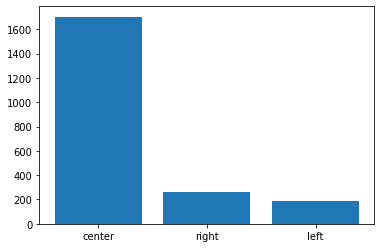

In [80]:
plt.figure()
plt.bar(('center','right','left'),[1703,263, 184])
plt.show()

In [303]:
word_list = []
lemmer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
df['text_lemmatized'] = df.content.apply(lemmatize_text)

In [82]:
df.head(3)

,text,url,title,content,bias,retweet_count,favorite_count,source_name,source,clean_content,clean_content_with_Stopwords,tags,polarity,polarity_score,subjectivity,subjectivity_score,text_lemmatized
0,"Army Officer, 4 Others Killed In Encounter In ...",https://www.ndtv.com/india-news/army-officer-4...,"Army Officer, 4 Personnel Killed In Encounter ...",an army officer and four other personnel were ...,3,9.0,63.0,ndtv,0,armi offic four personnel kill action encount ...,an army officer and four other personnel were ...,"[terrorism, armament, defense and military for...",-0.031250,Negative,0.318750,Low subjectivity,"[an, army, officer, and, four, other, personne..."
1,"#AryanKhan Case: No Bail For Him Today, Next H...",https://ndtv.com/india-news/mumbai-drug-bust-c...,"Aryan Khan Case: No Bail For Him Today, Next H...",aryan khan did not get bail today for the thir...,3,5.0,44.0,ndtv,0,aryan khan get bail today third time sinc arre...,aryan khan did not get bail today for the thir...,[drug abuse and traffic],-0.018687,Negative,0.407323,Low subjectivity,"[aryan, khan, did, not, get, bail, today, for,..."
2,RT @ndtvfeed: Ex-National Conference Leaders D...,https://www.ndtv.com/india-news/after-resignin...,"Ex-National Conference Leaders Devender Rana, ...",a day after resigning from the national confer...,1,2.0,0.0,ndtv,0,day resign nation confer devend rana former he...,a day after resigning from the national confer...,[appointments and executive changes],0.084060,Positive,0.199474,Low subjectivity,"[a, day, after, resigning, from, the, national..."


In [83]:
df['clean_text_lemmatized'] = df.clean_content.apply(lemmatize_text)

In [84]:
df.head(4)

,text,url,title,content,bias,retweet_count,favorite_count,source_name,source,clean_content,clean_content_with_Stopwords,tags,polarity,polarity_score,subjectivity,subjectivity_score,text_lemmatized,clean_text_lemmatized
0,"Army Officer, 4 Others Killed In Encounter In ...",https://www.ndtv.com/india-news/army-officer-4...,"Army Officer, 4 Personnel Killed In Encounter ...",an army officer and four other personnel were ...,3,9.0,63.0,ndtv,0,armi offic four personnel kill action encount ...,an army officer and four other personnel were ...,"[terrorism, armament, defense and military for...",-0.031250,Negative,0.318750,Low subjectivity,"[an, army, officer, and, four, other, personne...","[armi, offic, four, personnel, kill, action, e..."
1,"#AryanKhan Case: No Bail For Him Today, Next H...",https://ndtv.com/india-news/mumbai-drug-bust-c...,"Aryan Khan Case: No Bail For Him Today, Next H...",aryan khan did not get bail today for the thir...,3,5.0,44.0,ndtv,0,aryan khan get bail today third time sinc arre...,aryan khan did not get bail today for the thir...,[drug abuse and traffic],-0.018687,Negative,0.407323,Low subjectivity,"[aryan, khan, did, not, get, bail, today, for,...","[aryan, khan, get, bail, today, third, time, s..."
2,RT @ndtvfeed: Ex-National Conference Leaders D...,https://www.ndtv.com/india-news/after-resignin...,"Ex-National Conference Leaders Devender Rana, ...",a day after resigning from the national confer...,1,2.0,0.0,ndtv,0,day resign nation confer devend rana former he...,a day after resigning from the national confer...,[appointments and executive changes],0.084060,Positive,0.199474,Low subjectivity,"[a, day, after, resigning, from, the, national...","[day, resign, nation, confer, devend, rana, fo..."
3,"RT @ndtvfeed: US Has Lost AI Battle To China, ...",https://www.ndtv.com/world-news/us-has-lost-ar...,"US Has Lost AI Battle To China, Pentagon's Ex-...",china has won the artificial intelligence batt...,0,5.0,0.0,ndtv,0,china artifici intellig battl unit state head ...,china has won the artificial intelligence batt...,"[suspensions, dismissals and resignations, arm...",0.008113,Positive,0.385273,Low subjectivity,"[china, ha, won, the, artificial, intelligence...","[china, artifici, intellig, battl, unit, state..."


In [304]:
center_with_bias_words = df.loc[df['content'].str.contains('shiv sena|shivsena|aap|bjp|congress', case=False)]
center_with_bias_words = center_with_bias_words.loc[center_with_bias_words['bias']==3]
right = df.loc[df['bias']==1]
left = df.loc[df['bias']==0]
center = df.loc[df['bias']==3]
df_center_with_bias_words=pd.concat([left,right,center_with_bias_words])


In [305]:
def common_words_plot(df, political_affiliation, first_):
    stop_words=final_stop_words
    word_list = []
    lemmer = WordNetLemmatizer()
    for row in tqdm(df):
        words = [w for w in word_tokenize(row) if (w not in stop_words)]
        words = [lemmer.lemmatize(w) for w in words if (len(w) > 2)]
        word_list.append(words)
    word_list = [word for l in word_list for word in l]
    counter = Counter(word_list)
    common_ = counter.most_common()
    word = []
    count = []
    for common_word, word_count in common_:
        if common_word not in stop_words:
            word.append(common_word)
            count.append(word_count)
         #print(common_word)
    plt.figure(figsize=(15,9))
    sns.barplot(word[:first_], count[:first_]).set_title(f'Most Common Words from the {political_affiliation}',fontsize=20)
    plt.xlabel("Words",fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel("Counts",fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
final_stop_words

In [307]:
from nltk.util import ngrams
def n_gram_plot(df, n, political_affiliation, first_):
    stop_words=final_stop_words
    print('vectorizing...')
    vec = CountVectorizer(ngram_range=(n, n),stop_words=stop_words+['edited']).fit(df)
    print('transforming...')
    bag_of_words = vec.transform(df)
    sum_words = bag_of_words.sum(axis=0)
    print('building frequency...')
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    x,y=map(list,zip(*words_freq))
    grams = 'Bigrams'
    if n == 3: grams = 'Trigrams'
    if n == 4: grams = 'Quadgrams'
    print('plotting...')
    plt.figure(figsize=(15,9))
    sns.barplot(y[:first_],x[:first_],palette="GnBu_d").set_title(f'Most Common {grams} from the {political_affiliation}',fontsize=20)
    plt.xlabel("Bigrams",fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel("Counts",fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(rotation=45)
    plt.show()

100%|██████████| 263/263 [00:04<00:00, 53.32it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


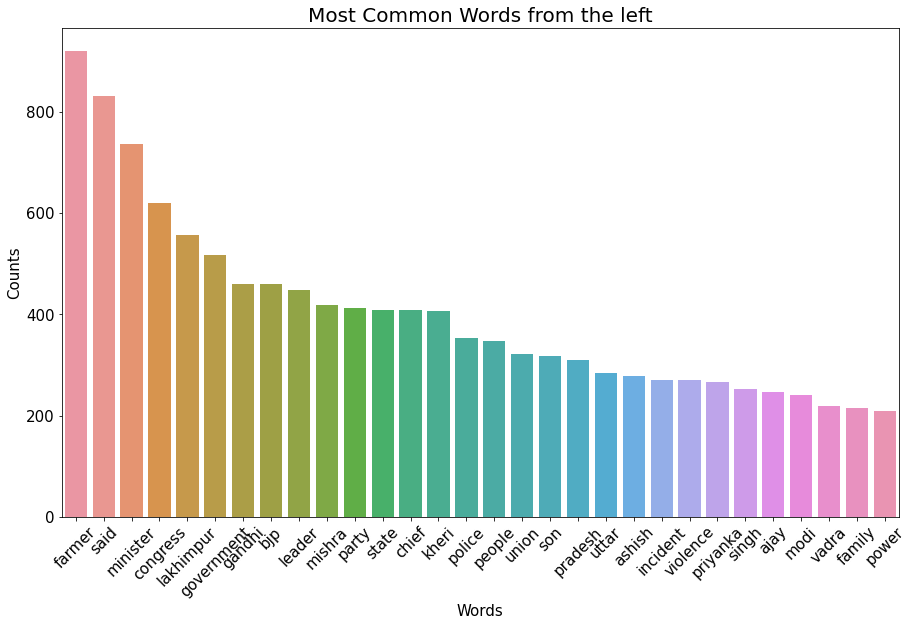

100%|██████████| 184/184 [00:05<00:00, 33.86it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


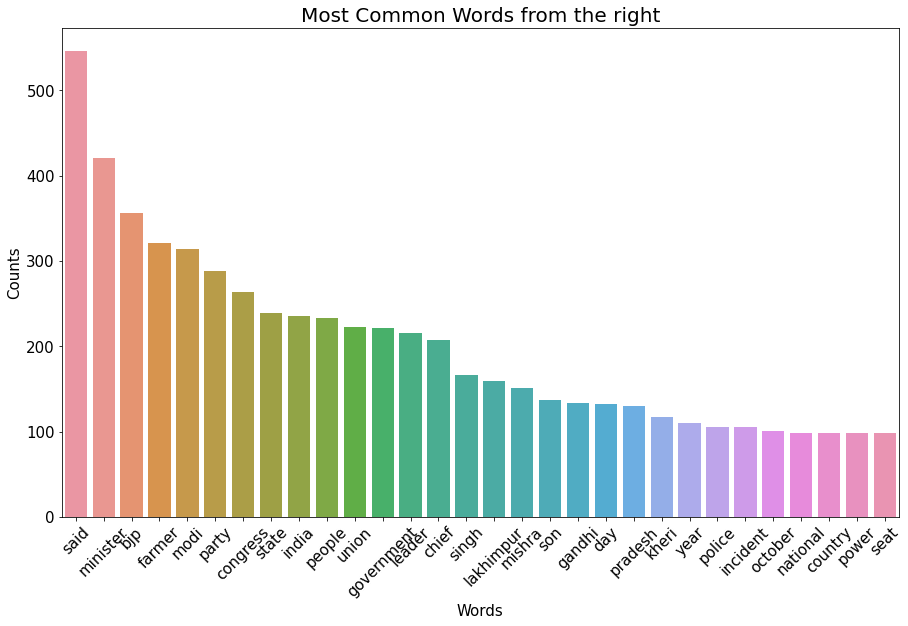

100%|██████████| 237/237 [00:06<00:00, 36.43it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


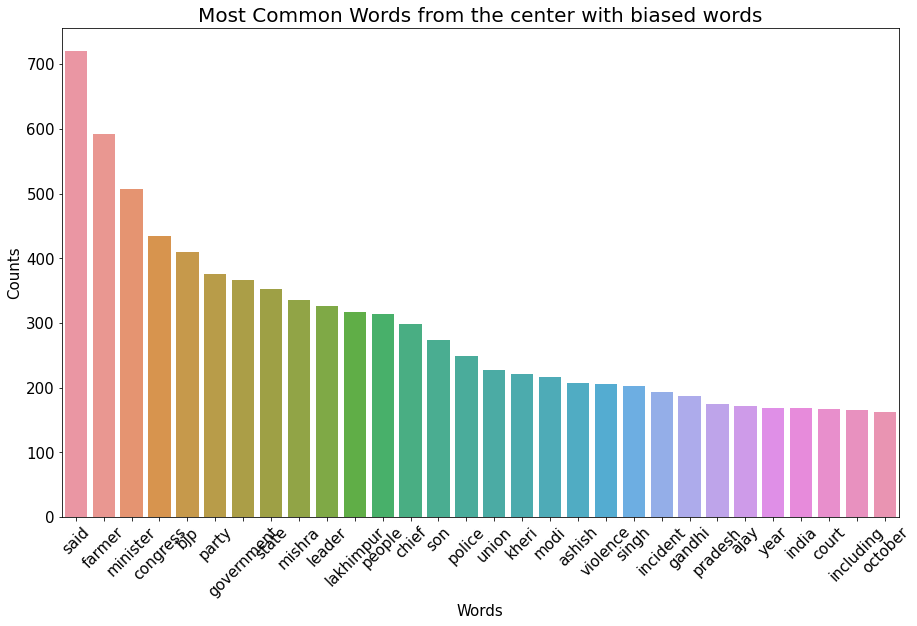

100%|██████████| 1703/1703 [00:12<00:00, 134.34it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


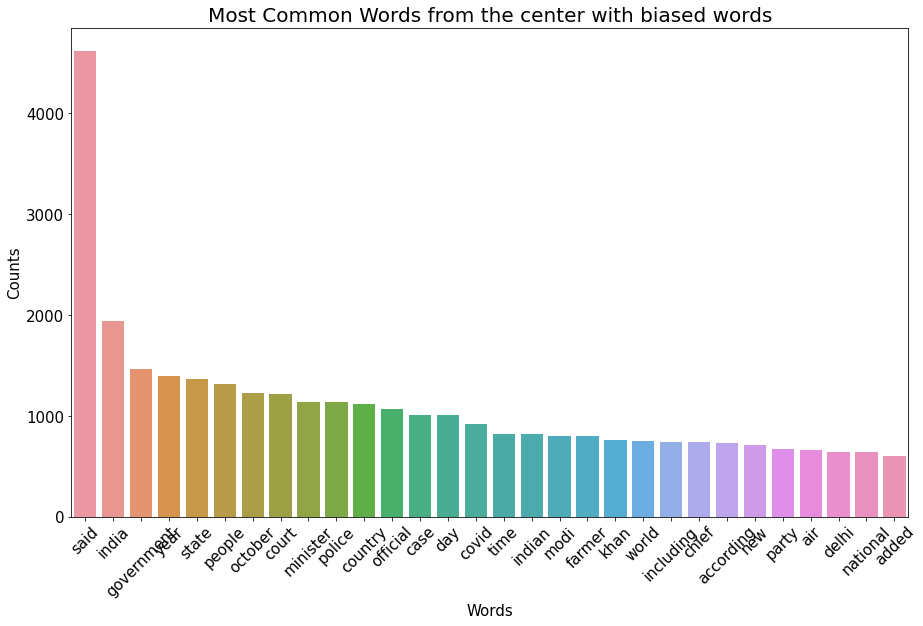

In [308]:
common_words_plot(left['clean_content_with_Stopwords'],'left',30)
common_words_plot(right['clean_content_with_Stopwords'],'right',30)
common_words_plot(center_with_bias_words['clean_content_with_Stopwords'],'center with biased words',30)
common_words_plot(center['clean_content_with_Stopwords'],'center with biased words',30)


vectorizing...
transforming...
building frequency...
plotting...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


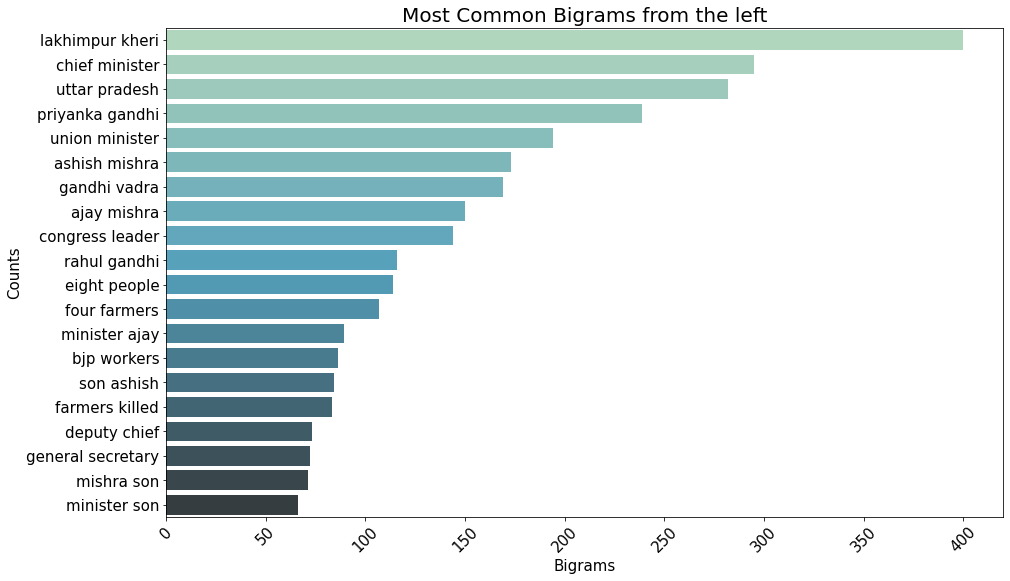

vectorizing...
transforming...
building frequency...
plotting...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


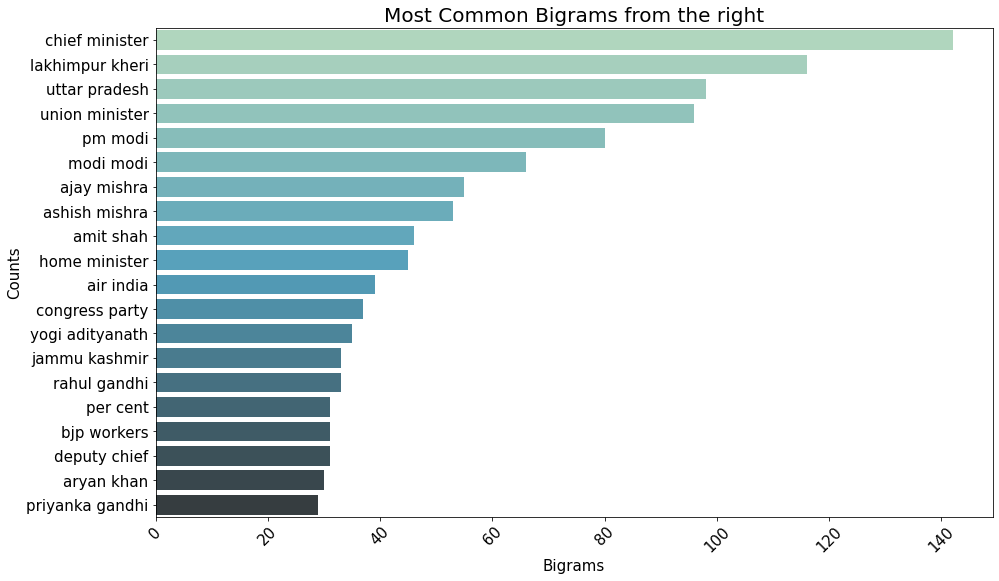

vectorizing...
transforming...
building frequency...
plotting...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


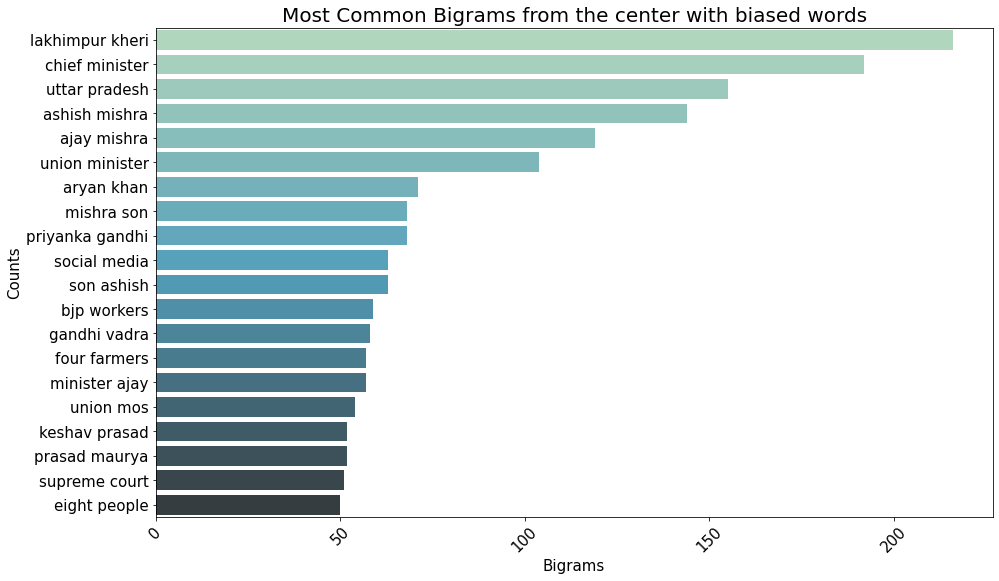

vectorizing...
transforming...
building frequency...
plotting...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


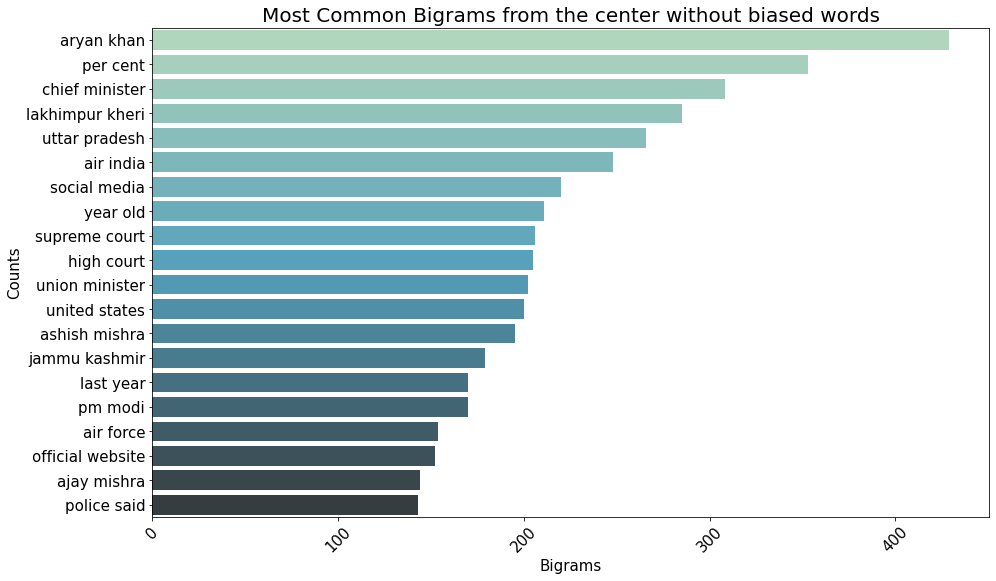

In [90]:
##BIGRAM COMMON WORDS
n_gram_plot(left['clean_content_with_Stopwords'],2,'left',20)
n_gram_plot(right['clean_content_with_Stopwords'],2,'right',20)
n_gram_plot(center_with_bias_words['clean_content_with_Stopwords'],2,'center with biased words',20)
n_gram_plot(center['clean_content_with_Stopwords'],2,'center without biased words',20)


vectorizing...
transforming...
building frequency...
plotting...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


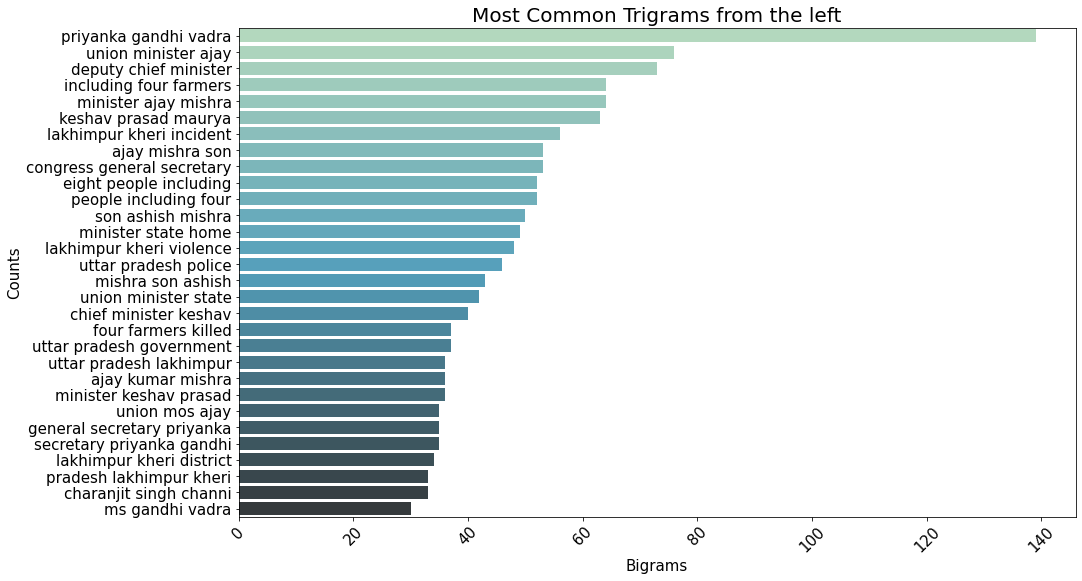

vectorizing...
transforming...
building frequency...
plotting...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


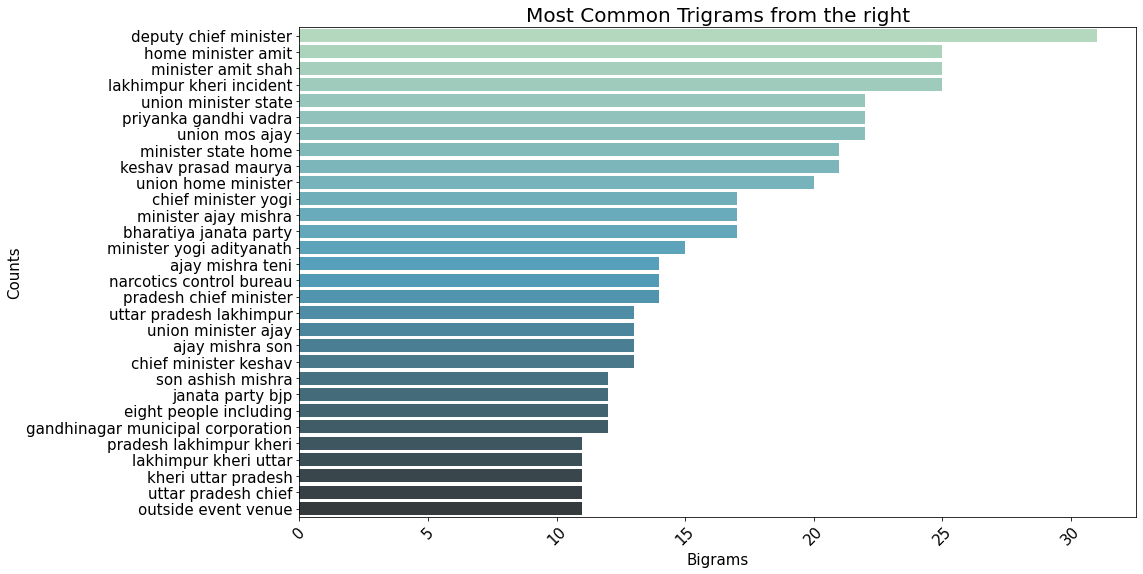

vectorizing...
transforming...
building frequency...
plotting...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


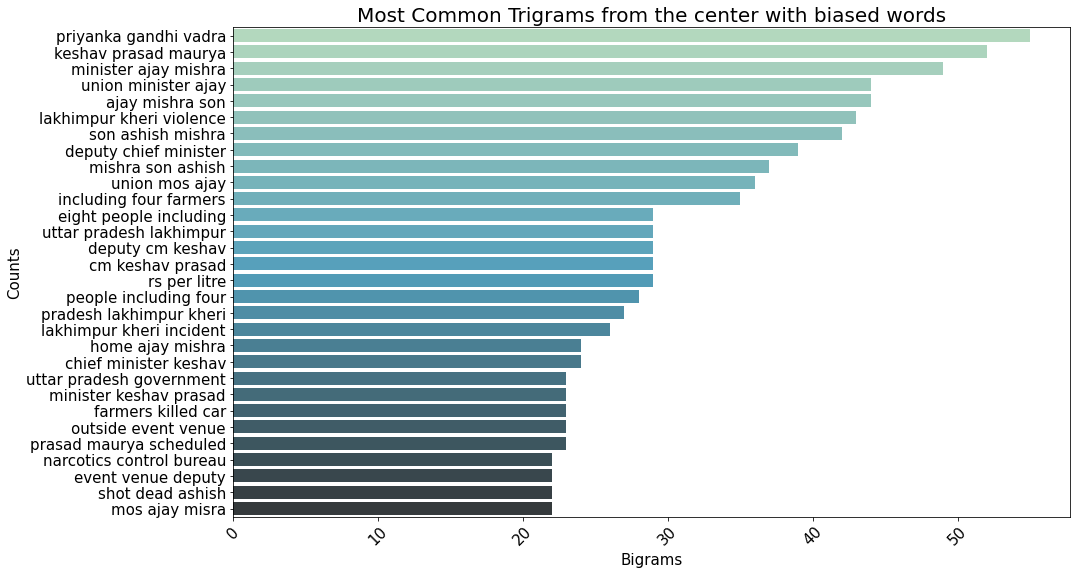

vectorizing...
transforming...
building frequency...
plotting...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


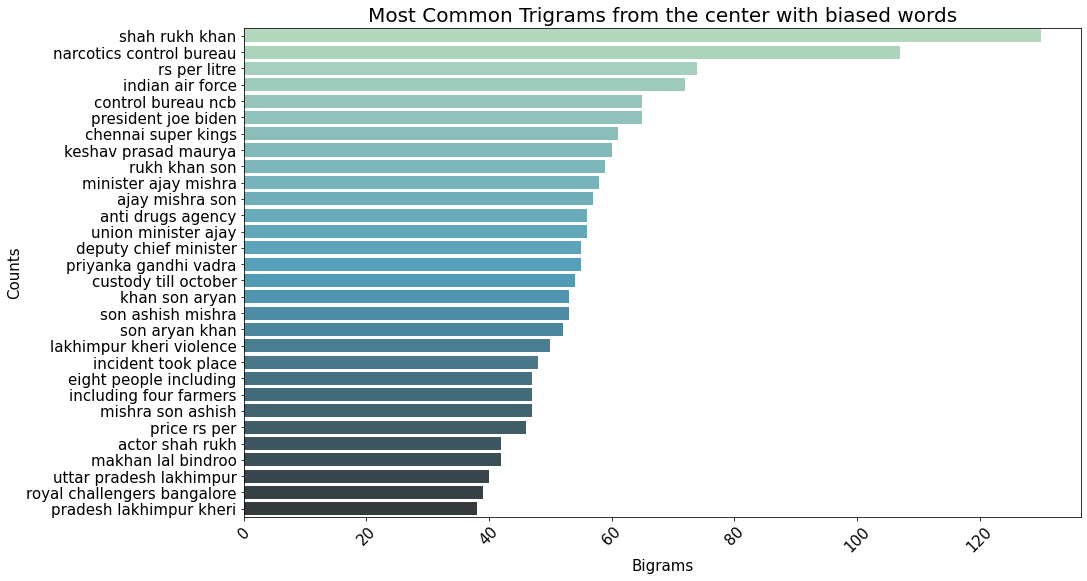

In [91]:
##TRIGRAM COMMON WORDS
n_gram_plot(left['clean_content_with_Stopwords'],3,'left',30)
n_gram_plot(right['clean_content_with_Stopwords'],3,'right',30)
n_gram_plot(center_with_bias_words['clean_content_with_Stopwords'],3,'center with biased words',30)
n_gram_plot(center['clean_content_with_Stopwords'],3,'center with biased words',30)


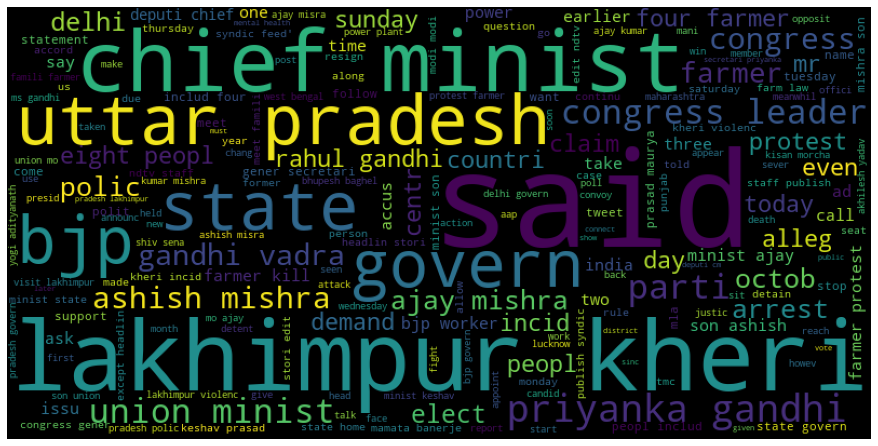

In [92]:
from wordcloud import WordCloud
###LEFT WORDCLOUD
text = left['clean_content'].values 
wordcloud = WordCloud(width=800, height=400).generate(str(text))
plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

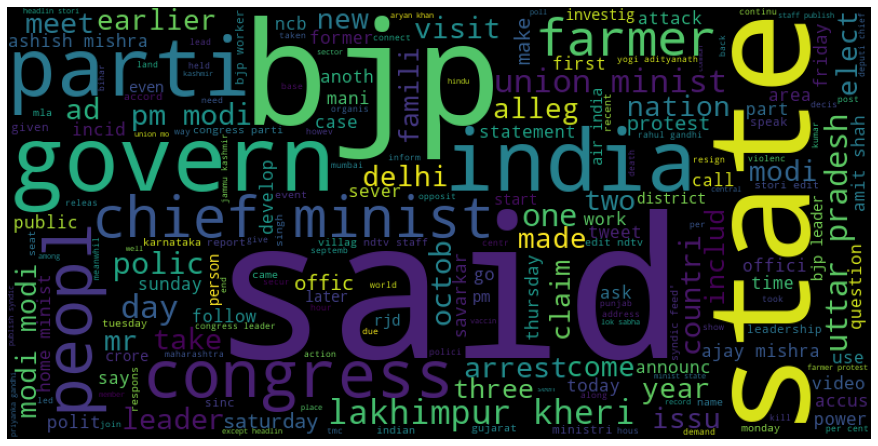

In [93]:
###RIGHT WORDCLOUD
text = right['clean_content'].values 
wordcloud = WordCloud(width=800, height=400).generate(str(text))
plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

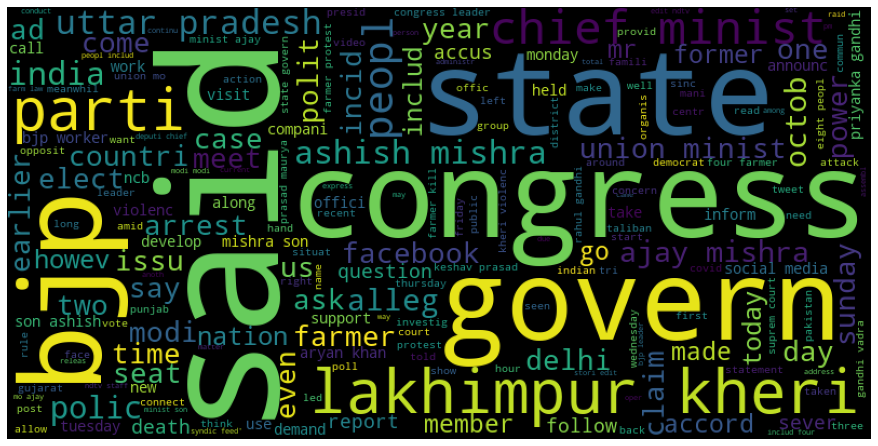

In [94]:
###CENTER WITH BIAS WORDS WORDCLOUD
text = center_with_bias_words['clean_content'].values 
wordcloud = WordCloud(width=800, height=400).generate(str(text))
plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

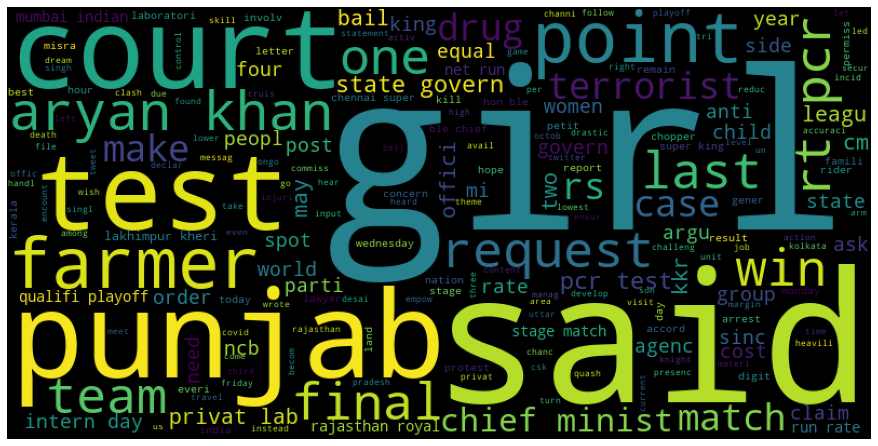

In [95]:
###CENTER WORDCLOUD
text = center['clean_content'].values 
wordcloud = WordCloud(width=800, height=400).generate(str(text))
plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


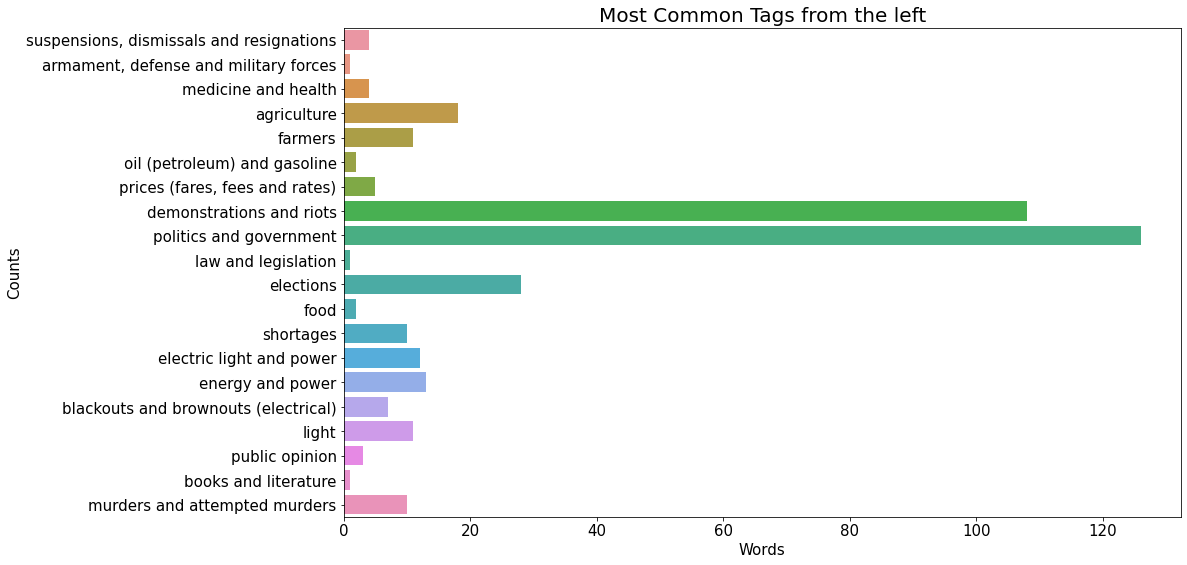

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


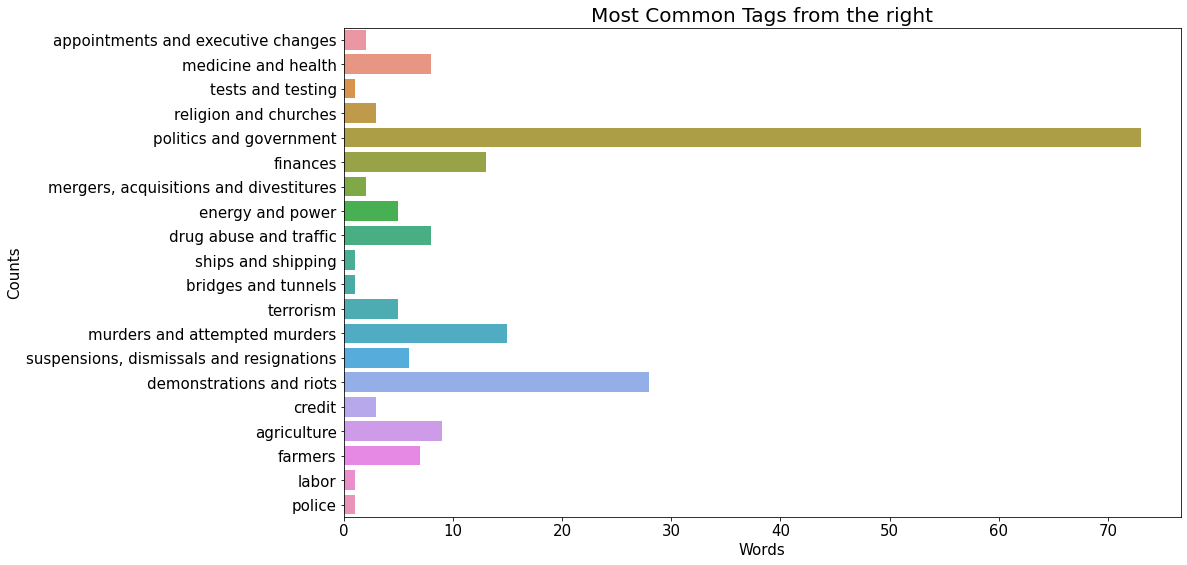

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


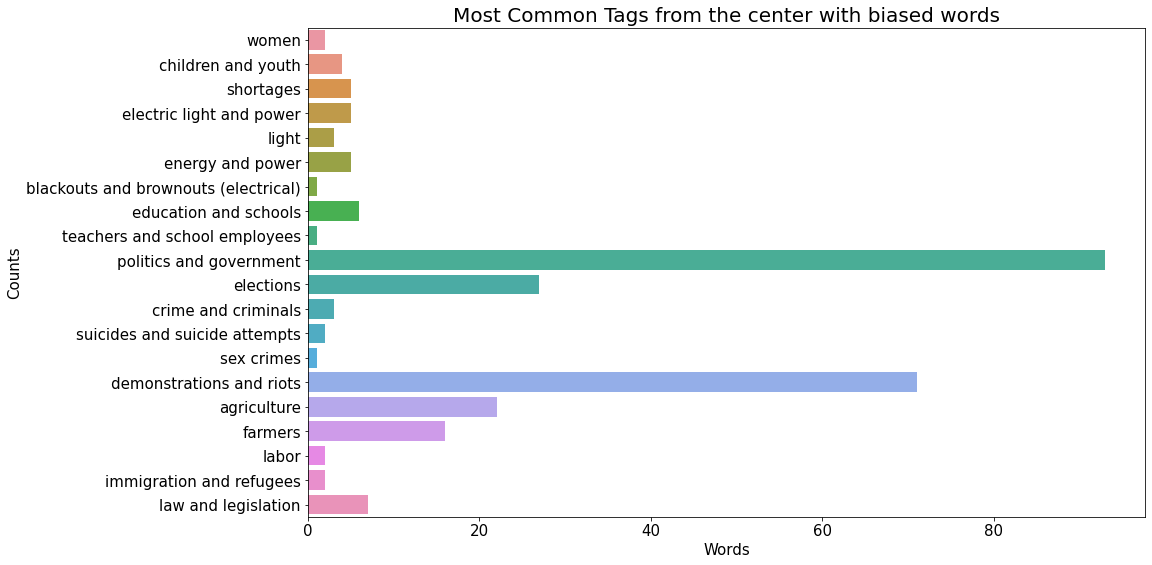

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


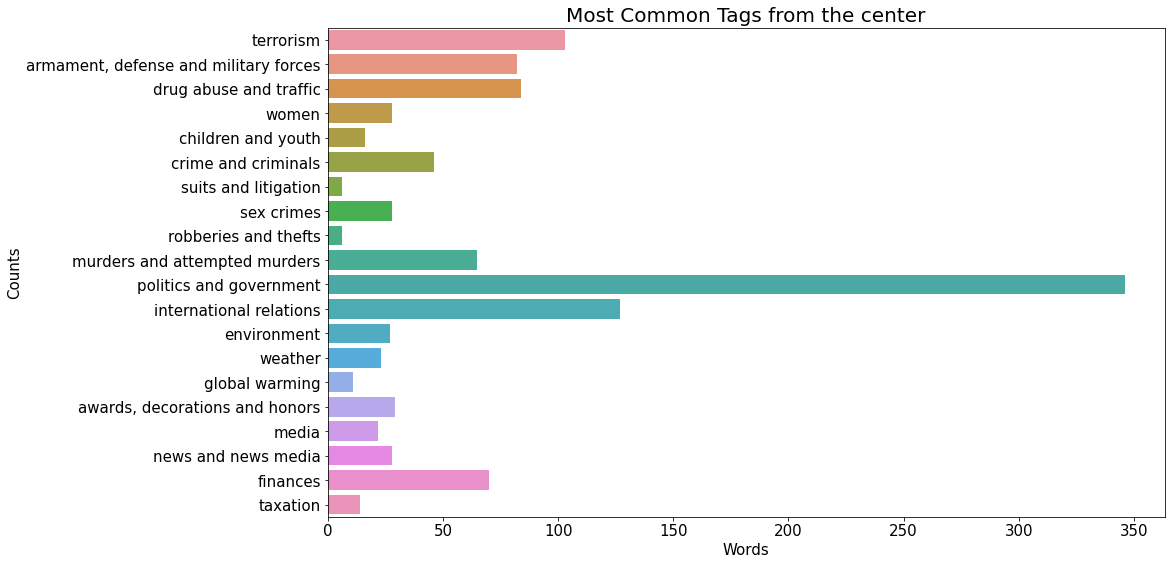

In [96]:
##TAGS
def common_tags_plot(df, political_affiliation, first_):
    # first_=20
    # political_affiliation='left'
    tagslist= []
    for x in df['tags']:
      for y in x:
        if y is not None:
          if y !=[]:
            if y !='':
              tagslist.append(y)
    tags=list(Counter(tagslist).keys()) # equals to list(set(words))
    tagscount=list(Counter(tagslist).values())
    plt.figure(figsize=(15,9))
    sns.barplot(tagscount[:first_],tags[:first_]).set_title(f'Most Common Tags from the {political_affiliation}',fontsize=20)
    plt.xlabel("Words",fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel("Counts",fontsize=15)
    plt.yticks(fontsize=15)
    #plt.xticks(rotation=90)
    plt.show()
common_tags_plot(left,'left',20)
common_tags_plot(right,'right',20)
common_tags_plot(center_with_bias_words,'center with biased words',20)
common_tags_plot(center,'center',20)


<Figure size 720x360 with 0 Axes>

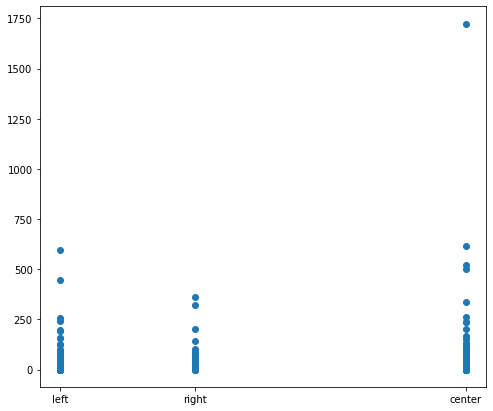

In [97]:
##ALL WITH THE TWITTER DATA
##RETWEETS
fig = plt.figure(figsize = (10, 5))
 
tweets = df['retweet_count']
bias= df['bias']
# creating the bar plot
plt.figure(figsize = (8, 7), facecolor = None)
plt.xticks([0,1,3],['left','right','center'])
plt.scatter(bias,tweets)
plt.show()

<Figure size 720x360 with 0 Axes>

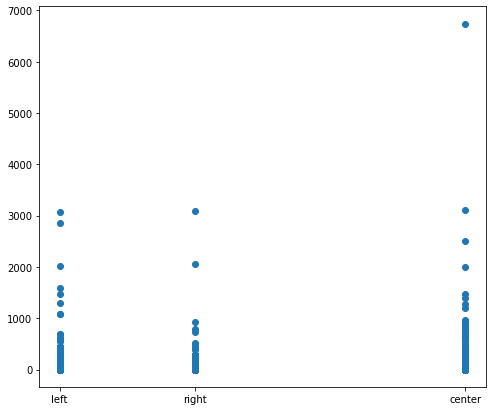

In [98]:
##ALL WITH THE TWITTER DATA
##favourite count
fig = plt.figure(figsize = (10, 5))
 
tweets = df['favorite_count']
bias= df['bias']
# creating the bar plot
plt.figure(figsize = (8, 7), facecolor = None)
plt.xticks([0,1,3],['left','right','center'])
plt.scatter(bias,tweets)
plt.show()

In [99]:
with open('/content/drive/MyDrive/project_data/model_data.pkl', 'wb') as fid:
      pickle.dump(df, fid)

# MODEL


In [309]:
cd /content/drive/MyDrive/project_data

/content/drive/MyDrive/project_data


In [311]:
infile = open('model_data.pkl','rb')
df = pickle.load(infile)

In [312]:
# from keras.preprocessing.sequence import pad_sequences
# max_features = 30000
# maxlen = 25
# X = df['clean_text_lemmatized']
# X = pad_sequences(X, maxlen = maxlen)
# y=df['bias']

In [313]:
//

SyntaxError: ignored

In [315]:
center_with_bias_words = df.loc[df['content'].str.contains('shiv sena|shivsena|aap|bjp|congress', case=False)]
center_without_bias_words = df.loc[~df['content'].str.contains('shiv sena|shivsena|aap|bjp|congress', case=False)]

center_without_bias_words = center_without_bias_words.loc[center_without_bias_words['bias']==3]

center_with_bias_words = center_with_bias_words.loc[center_with_bias_words['bias']==3]
right = df.loc[df['bias']==1]
left = df.loc[df['bias']==0]
#center = df.loc[df['bias']==3]

#df2=pd.concat([left,right,center_with_bias_words])


In [316]:
len(right)

184

In [317]:
len(left)


263

In [318]:
left=left.head(190)

In [319]:
len(center_without_bias_words)

1466

In [320]:
len(center_with_bias_words)


237

In [321]:
center_with_bias_words=center_with_bias_words.head(100)

In [322]:
center_without_bias_words=center_without_bias_words.head(100)


In [323]:
len(center_without_bias_words)

100

In [324]:
len(center_with_bias_words)


100

In [325]:
df2=pd.concat([left,right,center_with_bias_words,center_without_bias_words])


In [326]:
#REINDEXING
indx=[]
for i in range(len(df2)):
  indx.append(i)
df2.index=indx

In [327]:
df2

,text,url,title,content,bias,retweet_count,favorite_count,source_name,source,clean_content,clean_content_with_Stopwords,tags,polarity,polarity_score,subjectivity,subjectivity_score,text_lemmatized,clean_text_lemmatized
0,"RT @ndtvfeed: US Has Lost AI Battle To China, ...",https://www.ndtv.com/world-news/us-has-lost-ar...,"US Has Lost AI Battle To China, Pentagon's Ex-...",china has won the artificial intelligence batt...,0,5.0,0.0,ndtv,0,china artifici intellig battl unit state head ...,china has won the artificial intelligence batt...,"[suspensions, dismissals and resignations, arm...",0.008113,Positive,0.385273,Low subjectivity,"[china, ha, won, the, artificial, intelligence...","[china, artifici, intellig, battl, unit, state..."
1,"Karnataka Minister's Bizarre Remarks On ""Moder...",https://www.ndtv.com/india-news/karnataka-mini...,"Karnataka Minister's Bizarre Remarks On ""Moder...",karnataka health minister dr k sudhakar on sun...,0,13.0,71.0,ndtv,0,karnataka health minist dr k sudhakar sunday c...,karnataka health minister dr k sudhakar on sun...,[medicine and health],0.032089,Positive,0.454799,Low subjectivity,"[karnataka, health, minister, dr, k, sudhakar,...","[karnataka, health, minist, dr, k, sudhakar, s..."
2,Agitation Will Continue Till Demands Are Met: ...,https://ndtv.com/india-news/agitation-will-con...,Agitation Will Continue Till Demands Are Met: ...,the farmers' agitation will continue till all ...,0,23.0,257.0,ndtv,0,farmer agit continu till demand met includ rep...,the farmers' agitation will continue till all ...,"[agriculture, farmers]",-0.008333,Negative,0.377778,Low subjectivity,"[the, farmers', agitation, will, continue, til...","[farmer, agit, continu, till, demand, met, inc..."
3,"Petrol, Diesel Prices Hit New Highs https://t....",https://www.ndtv.com/business/petrol-and-diese...,"Petrol, Diesel Prices Hit New Highs. Check Lat...","petrol, diesel price today: petrol prices touc...",0,17.0,119.0,ndtv,0,petrol diesel price today petrol price touch n...,"petrol, diesel price today: petrol prices touc...","[oil (petroleum) and gasoline, prices (fares, ...",-0.008058,Negative,0.507231,High subjectivity,"[petrol,, diesel, price, today:, petrol, price...","[petrol, diesel, price, today, petrol, price, ..."
4,#MaharashtraBandh Today In Solidarity With Far...,https://www.ndtv.com/india-news/maharashtra-ba...,Maharashtra Bandh Live Updates: Bus Services A...,bus services were affected across maharashtra ...,0,21.0,78.0,ndtv,0,bu servic affect across maharashtra shop comme...,bus services were affected across maharashtra ...,[],0.123333,Positive,0.350000,Low subjectivity,"[bus, service, were, affected, across, maharas...","[bu, servic, affect, across, maharashtra, shop..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,"RT @ndtvfeed: With New Airport, Sindhudurg To ...",https://www.ndtv.com/india-news/with-new-airpo...,"With New Airport, Sindhudurg To Boost Tourism ...","in a major boost to tourism in maharashtra, es...",3,5.0,0.0,ndtv,0,major boost tourism maharashtra especi konkan ...,"in a major boost to tourism in maharashtra, es...",[travel and vacations],0.137041,Positive,0.403531,Low subjectivity,"[in, a, major, boost, to, tourism, in, maharas...","[major, boost, tourism, maharashtra, especi, k..."
570,RT @ndtvfeed: Multiple Places Searched After G...,https://www.ndtv.com/india-news/mundra-port-dr...,Multiple Places Searched After Gujarat Port Dr...,the nia on saturday conducted searches at vari...,3,10.0,0.0,ndtv,0,nia saturday conduct search variou locat diffe...,the nia on saturday conducted searches at vari...,"[drug abuse and traffic, search and seizure]",-0.041667,Negative,0.433333,Low subjectivity,"[the, nia, on, saturday, conducted, search, at...","[nia, saturday, conduct, search, variou, locat..."
571,"RT @ndtvfeed: India, US Discuss Indo-Pacific, ...",https://www.ndtv.com/india-news/india-us-discu...,"India, US Discuss Indo-Pacific, Regional Issue...",india and

In [328]:
# ## Divide the dataset into Train and Test
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)

In [329]:
######NaiiveBayes without Feature Selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score,classification_report,accuracy_score,confusion_matrix
from sklearn.naive_bayes import GaussianNB
## TFidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [330]:
X = df2['clean_content']
y=df2['bias']


In [331]:
# ## TFidf Vectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf_v=TfidfVectorizer(max_features=25000,ngram_range=(1,3))

In [332]:
X=tfidf_v.fit_transform(df2['clean_content']).toarray()


In [333]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [334]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [335]:
count_df = pd.DataFrame(X_train, columns=tfidf_v.get_feature_names())
count_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aa jao,aa jao ok,aaditya,aaditya thackeray,aadmi,aadmi parti,aadmi parti aap,aadmi parti claim,aai,...,zoo,zoo safari,zoo safari forest,zp,zp dhule,zp dhule nandurbar,zp panchayat,zp panchayat samiti,zp seat,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [336]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()
from sklearn import metrics
import numpy as np
import itertools
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
cm
#plot_confusion_matrix(cm, classes=pred.c)##bias=left 0 right 1 unbiased 3
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred))

accuracy:   0.590
              precision    recall  f1-score   support

           0       0.45      0.89      0.60        47
           1       0.87      0.34      0.49        58
           3       0.70      0.59      0.64        68

    accuracy                           0.59       173
   macro avg       0.67      0.61      0.58       173
weighted avg       0.69      0.59      0.58       173

[[42  1  4]
 [25 20 13]
 [26  2 40]]


In [337]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()
from sklearn import metrics
import numpy as np
import itertools
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
cm
#plot_confusion_matrix(cm, classes=pred.c)##bias=left 0 right 1 unbiased 3
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred))

accuracy:   0.590
              precision    recall  f1-score   support

           0       0.45      0.89      0.60        47
           1       0.87      0.34      0.49        58
           3       0.70      0.59      0.64        68

    accuracy                           0.59       173
   macro avg       0.67      0.61      0.58       173
weighted avg       0.69      0.59      0.58       173

[[42  1  4]
 [25 20 13]
 [26  2 40]]


In [338]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier=RandomForestClassifier(n_estimators=10).fit(X_train,y_train)
prediction=rf_classifier.predict(X_test)
y.value_counts()
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print(confusion_matrix(y_test,prediction))
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))


[[28 11  8]
 [15 32 11]
 [17  7 44]]
0.6011560693641619
              precision    recall  f1-score   support

           0       0.47      0.60      0.52        47
           1       0.64      0.55      0.59        58
           3       0.70      0.65      0.67        68

    accuracy                           0.60       173
   macro avg       0.60      0.60      0.60       173
weighted avg       0.62      0.60      0.60       173



# RF  Manual Hyperparameter Tuning

In [339]:
### Manual Hyperparameter Tuning
# {'criterion': 'entropy',
#  'max_depth': 100,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'n_estimators': 600}
model=RandomForestClassifier(n_estimators=900,criterion='entropy',
                             max_features='sqrt',min_samples_leaf=1,min_samples_split=2,random_state=100).fit(X_train,y_train)
predictions=model.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))
print(classification_report(y_test,predictions))

[[31  7  9]
 [13 31 14]
 [19  1 48]]
0.6358381502890174
              precision    recall  f1-score   support

           0       0.49      0.66      0.56        47
           1       0.79      0.53      0.64        58
           3       0.68      0.71      0.69        68

    accuracy                           0.64       173
   macro avg       0.65      0.63      0.63       173
weighted avg       0.67      0.64      0.64       173



#RF WITH RANDOMSEARCH CV

RF WITH RANDOMSEARCH CV

In [340]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 500,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [ ]:
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=10,cv=3,verbose=2,
                               random_state=50,n_jobs=-1)
### fit the randomized model
rf_randomcv.fit(X_train,y_train)

In [ ]:
rf_randomcv.best_params_

In [ ]:
best_random_grid=rf_randomcv.best_estimator_
from sklearn.metrics import accuracy_score
y_pred=best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: \n {}".format(classification_report(y_test,y_pred)))

#RF WITH GridSearchCV


RF WITH GridSearchCV


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': [rf_randomcv.best_params_['criterion']],
    'max_depth': [rf_randomcv.best_params_['max_depth']],
    'max_features': [rf_randomcv.best_params_['max_features']],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'], 
                         rf_randomcv.best_params_['min_samples_leaf']+2, 
                         rf_randomcv.best_params_['min_samples_leaf'] + 4],
    'min_samples_split': [rf_randomcv.best_params_['min_samples_split'] - 2,
                          rf_randomcv.best_params_['min_samples_split'] - 1,
                          rf_randomcv.best_params_['min_samples_split'], 
                          rf_randomcv.best_params_['min_samples_split'] +1,
                          rf_randomcv.best_params_['min_samples_split'] + 2],
    'n_estimators': [rf_randomcv.best_params_['n_estimators'] - 200, rf_randomcv.best_params_['n_estimators'] - 100, 
                     rf_randomcv.best_params_['n_estimators'], 
                     rf_randomcv.best_params_['n_estimators'] + 100, rf_randomcv.best_params_['n_estimators'] + 200]
}

print(param_grid)
#### Fit the grid_search to the data
rf=RandomForestClassifier()
grid_search=GridSearchCV(estimator=rf,param_grid=param_grid,cv=10,n_jobs=-1,verbose=2)
grid_search.fit(X_train,y_train)


# Multinomial with Hyperparameter


In [357]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(param)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [359]:
pip install tpot


In [363]:
from tpot import TPOTClassifier

tpot_classifier = TPOTClassifier(generations= 3, population_size= 20, offspring_size= 10,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestClassifier':param}, 
                                 cv = 4, scoring = ['accuracy','recall','precision'])vvvvvv
tpot_classifier.fit(X_train,y_train)

Optimization Progress:   0%|          | 0/56 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6732920792079208

Generation 2 - Current best internal CV score: 0.6732920792079208

Generation 3 - Current best internal CV score: 0.6732920792079208

Best pipeline: RandomForestClassifier(input_matrix, criterion=gini, max_depth=340, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['entropy',
                                                                                      'gini'],
                                                                        'max_depth': [10,
                                                                                      120,
                                                                                      230,
                                                                                      340,
                                                                                      450,
                                                                                      560,
                                                                                      670,
                                                                                      780,
                                                                                 

In [364]:
### Manual Hyperparameter Tuning
# {'criterion': 'entropy',
#  'max_depth': 100,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'n_estimators': 600}
model=RandomForestClassifier( criterion='gini', max_depth=340, max_features='auto', min_samples_leaf=2, min_samples_split=5, n_estimators=2000).fit(X_train,y_train)
predictions=model.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))
print(classification_report(y_test,predictions))

[[30  7 10]
 [10 35 13]
 [19  1 48]]
0.653179190751445
              precision    recall  f1-score   support

           0       0.51      0.64      0.57        47
           1       0.81      0.60      0.69        58
           3       0.68      0.71      0.69        68

    accuracy                           0.65       173
   macro avg       0.67      0.65      0.65       173
weighted avg       0.68      0.65      0.66       173



In [ ]:
pip install optuna


In [ ]:
import optuna
import sklearn.svm
def objective(trial):

    classifier = trial.suggest_categorical('classifier', ['RandomForest', 'SVC'])
    
    if classifier == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 200, 2000,10)
        max_depth = int(trial.suggest_float('max_depth', 10, 100, log=True))

        clf = sklearn.ensemble.RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth)
    else:
        c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
        
        clf = sklearn.svm.SVC(C=c, gamma='auto')

    return sklearn.model_selection.cross_val_score(
        clf,X_train,y_train, n_jobs=-1, cv=3).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
rf=RandomForestClassifier(n_estimators=330,max_depth=30)
rf.fit(X_train,y_train)

In [ ]:
y_pred=rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [361]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)

In [ ]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)

In [362]:
from sklearn.metrics import accuracy_score
y_pred=text_clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: \n {}".format(classification_report(y_test,y_pred)))

NotFittedError: ignored